In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
from shapely import geometry
from geopy.distance import geodesic
import networkx as nx
from quetzal.model import stepmodel
from quetzal.engine.add_network import NetworkCaster
from quetzal.engine.pathfinder import sparse_los_from_nx_graph

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

# Preparation of the transport network.
## Saves distance for PT links.
## Needs all networks and a rail network

In [2]:
input_path = '../input_static/'
output_path = '../output/'
model_path = '../model/'

In [3]:
sm = stepmodel.read_json(model_path + 'de_pt_network_agg')

In [4]:
# Road network to map bus and coach
road = stepmodel.read_json(input_path + 'de_road_network')

In [5]:
# Load rail network from DB Netze
rail_links = gpd.read_file(input_path + 'de_rail_network_2017', engine='shapefile')

In [6]:
rail_links.head(2)

,mifcode,strecke_nr,richtung,laenge,von_km_i,bis_km_i,von_km_l,bis_km_l,elektrifiz,bahnnutzun,geschwindi,strecke_ku,gleisanzah,bahnart,kmspru_typ,kmspru_t00,geometry
0,xka_mrk_830,1000,0,136.0,117090058,117100094,"170,9 + 58","171,0 + 94",Oberleitung,Gz-Bahn,ab 50 bis 100 km/h,Flensburg-Weiche - Flensb. Gr,eingleisig,Hauptbahn,None,None,"LINESTRING Z (9.38321 54.74343 0.00000, 9.3834..."
1,xka_mrk_830,1000,0,3303.0,117100094,117440000,"171,0 + 94","174,4 + 0",Oberleitung,Gz-Bahn,ab 50 bis 100 km/h,Flensburg-Weiche - Flensb. Gr,zweigleisig,Hauptbahn,None,None,"LINESTRING Z (9.38390 54.74459 0.00000, 9.3840..."


In [7]:
# Where are passenger trains allowed?
rail_links['bahnnutzun'].unique()

array(['Gz-Bahn', 'Pz/Gz-Bahn', 'Pz-Bahn', 'S-Bahn', 'Hafenbahn',
       'Seilzugbahn'], dtype=object)

In [8]:
# Drop freight lines
rail_links = rail_links.loc[rail_links['bahnnutzun'].isin(['Pz/Gz-Bahn', 'Pz-Bahn', 'S-Bahn'])]

<AxesSubplot:>

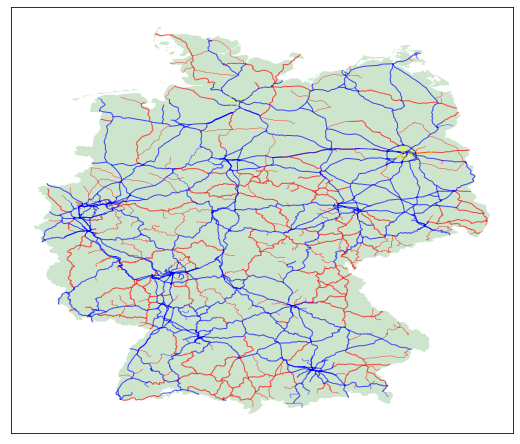

In [9]:
rail_links['color'] = rail_links['elektrifiz'].map(
    {'Oberleitung': 'blue', 'nicht elektrifiziert': 'red', 'Stromschiene': 'yellow'})
rail_links['width'] = rail_links['bahnart'].map(
    {'Hauptbahn': 1, 'Nebenbahn': .5, 'Schmalspurbahn': .2, 'Breitspurbahn': .3})
rail_links.plot(color=rail_links['color'], linewidth=rail_links['width'], alpha=.7, ax=sm.plot(
    'zones', alpha=.2, color='green', figsize=(9,9)))

In [10]:
# Rename relevant columns
rail_links = rail_links.rename(columns={'laenge': 'length', 'strecke_nr': 'id'})

In [11]:
# Map electrification
rail_links['electrified'] = rail_links['elektrifiz'].map(
    {'Oberleitung': True, 'nicht elektrifiziert': False, 'Stromschiene': True})

<AxesSubplot:xlabel='elektrifiz'>

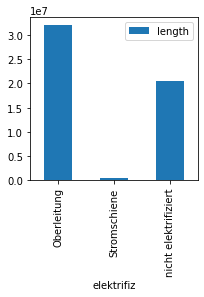

In [12]:
# Electrification distribution
rail_links.groupby('elektrifiz').agg({'length': 'sum'}).plot.bar(subplots=False, figsize=(3,3))

In [13]:
rail_links['maxspeed'] = rail_links['geschwindi'].apply(lambda s: int(s[-8:-5]) if s else np.nan)

<AxesSubplot:xlabel='maxspeed'>

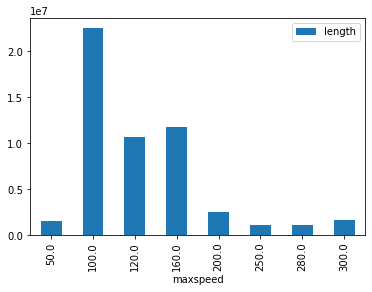

In [14]:
# Speed limit distribution
rail_links.groupby('maxspeed').agg({'length': 'sum'}).plot.bar(subplots=False)

In [15]:
len(rail_links)

14156

## Build rail network graph

In [16]:
# Build nodes lists
rail_links['node_a_geo'] = rail_links['geometry'].apply(lambda l: geometry.Point(l.coords[0][0:2]))
rail_links['node_b_geo'] = rail_links['geometry'].apply(lambda l: geometry.Point(l.coords[-1][0:2]))

In [17]:
# Create node series
a_nodes = gpd.GeoSeries(rail_links['node_a_geo'].rename('geometry'))
a_nodes.reset_index(drop=True, inplace=True)
a_nodes[a_nodes.isna()]

GeoSeries([], Name: geometry, dtype: geometry)

In [19]:
# Map origin nodes to origin nodes
rail_links['a'] = np.nan
for ind, geo in tqdm(a_nodes.items(), total=len(a_nodes)):
    rail_links['a_match'] = a_nodes.intersects(geo.buffer(1e-5))
    rail_links.loc[rail_links['a_match']==True, 'a'] = ind

100%|████████████████████████████████████████████████████████████████████████████| 14156/14156 [17:35<00:00, 13.41it/s]


In [22]:
len(rail_links.loc[rail_links['a'].notna()])

12528

In [23]:
# Number of unique nodes in total
len(rail_links['a'].unique())

12227

In [24]:
# Redindex uniquely
to_append = rail_links.loc[
    rail_links['a'].isna(), 'node_a_geo'].rename('geometry')
indicies = [i for i in range(a_nodes.index.max(), a_nodes.index.max() + len(to_append))]
to_append.index = indicies
rail_links.loc[rail_links['a'].isna(), 'a'] = indicies
rail_links['a'] = rail_links['a'].apply(int)

In [25]:
# Add NaN nodes to a_nodes
a_nodes = a_nodes.append(to_append)
a_nodes[a_nodes.isna()]

GeoSeries([], dtype: geometry)

In [26]:
# Drop duplicates
a_nodes = a_nodes.loc[list(rail_links['a'].unique())]
len(a_nodes)

13854

In [27]:
# Map destination nodes to origin nodes
b_nodes = gpd.GeoSeries(rail_links['node_b_geo'])
rail_links['b'] = np.nan
for ind, geo in tqdm(a_nodes.items(), total=len(a_nodes)):
    rail_links['b_match'] = b_nodes.intersects(geo.buffer(1e-6))
    rail_links.loc[rail_links['b_match']==True, 'b'] = ind

100%|████████████████████████████████████████████████████████████████████████████| 13854/13854 [16:42<00:00, 13.82it/s]


In [28]:
# Number of matches
len(rail_links.loc[rail_links['b'].notna()])

11643

In [33]:
# Assign indicies to unique nodes
to_append = rail_links.loc[rail_links['b'].isna(), 'node_b_geo'].rename('geometry')
indicies = [i for i in range(a_nodes.index.max()+1,
                             a_nodes.index.max()+1 + len(rail_links.loc[rail_links['b'].isna()]))]
to_append.index = indicies
rail_links.loc[rail_links['b'].isna(), 'b'] = indicies
rail_links['b'] = rail_links['b'].apply(int)

In [34]:
rail_links.loc[rail_links[['a', 'b', 'length']].isna().any(axis=1)]

,mifcode,id,richtung,length,von_km_i,bis_km_i,von_km_l,bis_km_l,elektrifiz,bahnnutzun,...,color,width,electrified,maxspeed,node_a_geo,node_b_geo,a,a_match,b,b_match


In [42]:
rail_nodes = a_nodes.append(to_append).rename('geometry')

In [43]:
len(rail_nodes)

16367

In [44]:
rail_nodes[rail_nodes.isna()]

GeoSeries([], Name: geometry, dtype: geometry)

In [49]:
rail_nodes = gpd.GeoDataFrame(rail_nodes)

In [67]:
# Save links and nodes
rail_links[['a', 'b', 'geometry']].to_file(input_path + 'de_rail_network_2017_links.geojson', driver='GeoJSON')
rail_nodes.to_file(input_path + 'de_rail_network_2017_nodes.geojson', driver='GeoJSON')

## Assigning real network length

We need a method to find the clostest rail/road node to each PT stop and match the link with the real network. Quetzal's network caster can do this.

In [45]:
# Test nodeset integrity
try:
    sm.integrity_test_nodeset_consistency()
except AssertionError:
    print('Missing nodes: ' + str(len(sm.missing_nodes)))
    sm.links = sm.links.loc[~((sm.links['a'].isin(sm.missing_nodes)) | (sm.links['b'].isin(sm.missing_nodes)))]
    try:
        sm.integrity_test_nodeset_consistency()
    except AssertionError:
        print('Orphan nodes: ' + str(len(sm.orphan_nodes)))
        sm.nodes = sm.nodes.drop(sm.orphan_nodes)
        sm.integrity_test_nodeset_consistency()

Missing nodes: 3
Orphan nodes: 2
no road_links or road_nodes


### Match nodes

In [50]:
# Network caster for rail lines
nc = NetworkCaster(sm.nodes.loc[sm.nodes['route_type'].isin(['rail_short', 'rail_long'])],
                   sm.links.loc[sm.links['route_type'].isin(['rail_short', 'rail_long'])],
                   rail_nodes, rail_links)

In [51]:
# The quick approach maps only nodes, not links to the network's geometry
nc.dumb_cast(replace_geometry=False)

index of one and many should not contain duplicates


nearest_link: 100%|██████████████████████████████████████████████████████████| 17980/17980 [00:00<00:00, 144582.37it/s]


In [52]:
nc.links.sample()

,a,b,route_type,geometry,link_sequence,route_id,time,trip_id,length,headway,price,road_node_list,road_link_list,road_a,road_b,road_geometry
index,,,,,,,,,,,,,,,,
r_s_162387,DE712_r_s_3,DE712_r_s_2,rail_short,"LINESTRING (8.60576 50.08221, 8.67230 50.10442)",3,rail_short_126,420,rail_short_47797,7755,1800,4.194761,[],[],16896,4476,"LINESTRING (8.612072 50.094321, 8.665621 50.10..."


<AxesSubplot:>

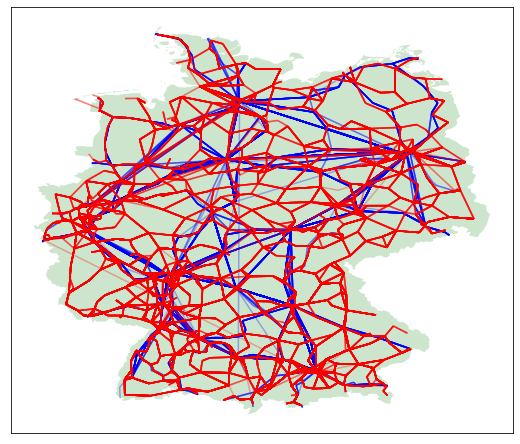

In [53]:
nc.links['color'] = nc.links['route_type'].map({'rail_long': 'blue', 'rail_short': 'red'})
gpd.GeoDataFrame(nc.links).plot(color=nc.links['color'], alpha=.3, ax=sm.plot(
    'zones', color='green', alpha=.2, figsize=(9,9)))

In [54]:
# Do the links tables have the same length?
len(nc.links) - len(sm.links.loc[sm.links['route_type'].isin(['rail_short', 'rail_long'])])

0

In [55]:
# The same for road PT modes
nc_road = NetworkCaster(sm.nodes.loc[sm.nodes['route_type'].isin(['bus', 'coach'])],
                        sm.links.loc[sm.links['route_type'].isin(['bus', 'coach'])],
                        road.road_nodes, road.road_links)

In [56]:
nc_road.dumb_cast(replace_geometry=False)

nearest_link: 100%|██████████████████████████████████████████████████████████| 12600/12600 [00:00<00:00, 122044.86it/s]


<AxesSubplot:>

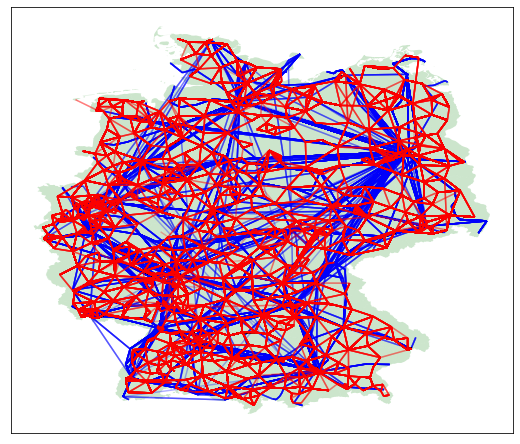

In [57]:
nc_road.links['color'] = nc_road.links['route_type'].map({'coach': 'blue', 'bus': 'red'})
gpd.GeoDataFrame(nc_road.links).plot(color=nc_road.links['color'], alpha=.3, ax=sm.plot(
    'zones', color='green', alpha=.2, figsize=(9,9)))

In [58]:
nc_road.links.sample()

,a,b,route_type,geometry,link_sequence,route_id,time,trip_id,length,headway,price,road_node_list,road_link_list,road_a,road_b,road_geometry,color
index,,,,,,,,,,,,,,,,,
bus_235566,DE932_bus_0,DE939_bus_0,bus,"LINESTRING (8.80558 53.61084, 9.41603 53.57911)",2,bus_9660,300,bus_19552,67606,600,0.0,[],[],1656921588,2613978955,"LINESTRING (8.8164637 53.624871, 9.4204492 53....",red


### Compute lengths

Pathfinding for all links takes too long. Thus, make samples by mode and build average ratios

In [59]:
# Method to map network lengths on an OD pair of mapped nodes
def get_length_from_od(od_pair):
    # Compute shortest paths
    los = sparse_los_from_nx_graph(network_graph, od_pair)
    return los.loc[los['gtime']>0, 'gtime'].mean()

In [60]:
sample_dict = {}
tqdm.pandas()

In [61]:
# rail modes
nc.links['od_pair'] = [set([a,b]) for a,b in tuple(zip(
    nc.links['road_a'], nc.links['road_b']))]
network_graph = nx.DiGraph()
network_graph.add_weighted_edges_from(
    rail_links[['a', 'b', 'length']].values.tolist())
network_graph = network_graph.to_undirected()
for mode in ['rail_long', 'rail_short']:
    sample_df = nc.links.iloc[0:0]
    sample_df['geo_length'] = np.nan
    iters = 0
    while len(sample_df) < 100 and iters < 5000:
        # The rail graph has gaps why we need iteration
        sample = nc.links.loc[nc.links['route_type']==mode].sample(10)
        sample['network_length'] = sample['od_pair'].apply(get_length_from_od)
        mask = sample['network_length']>0
        if len(sample.loc[mask]) > 0:
            sample.loc[mask, 'geo_length'] = sample.loc[mask, 'geometry'].apply(
                lambda l: int(geodesic(l.coords[0], l.coords[-1]).m))
            sample_df.append(sample.loc[mask])
        iters += 10
    sample_dict[mode] = sample_df
    print(mode+': '+str(iters)+' iterations; '+str(len(sample_df))+' samples')

rail_long: 5000 iterations; 0 samples
rail_short: 5000 iterations; 0 samples


In [69]:
# Road modes
nc_road.links['od_pair'] = [set([a,b]) for a,b in tuple(zip(
    nc_road.links['road_a'], nc_road.links['road_b']))]
network_graph = nx.DiGraph()
network_graph.add_weighted_edges_from(
    road.road_links[['a', 'b', 'length']].values.tolist())
for mode in ['bus', 'coach']:
    sample = nc_road.links.loc[nc_road.links['route_type']==mode].sample(300)
    sample['network_length'] = sample['od_pair'].progress_apply(get_length_from_od)
    sample['geo_length'] = sample['geometry'].apply(
        lambda l: int(geodesic(l.coords[0], l.coords[-1]).m))
    sample_dict[mode] = sample

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:55<00:00,  1.75s/it]


array([[<AxesSubplot:title={'center':'geo_length'}>,
        <AxesSubplot:title={'center':'network_length'}>]], dtype=object)

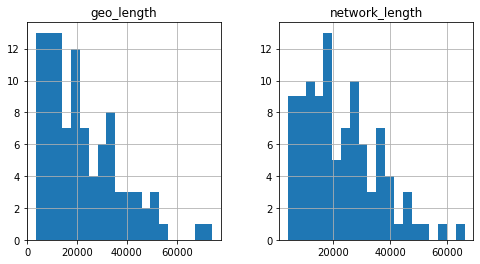

In [70]:
sample_dict['bus'][['geo_length', 'network_length']].hist(bins=20, figsize=(8,4))

In [73]:
# Dictionary with length correction factors (can include defaults)
factor_dict = {'rail_short': 1.15, 'rail_long': 1.3}
sample_dict.pop('rail_short')
sample_dict.pop('rail_long')

,a,b,route_type,geometry,link_sequence,route_id,time,trip_id,length,headway,price,road_node_list,road_link_list,road_a,road_b,road_geometry,color,od_pair,geo_length
index,,,,,,,,,,,,,,,,,,,


In [74]:
# Compute factors
for mode, df in sample_dict.items():
    factor_dict[mode] = (df['network_length'] / df['geo_length']).mean()

In [75]:
factor_dict

{'rail_short': 1.15,
 'rail_long': 1.3,
 'bus': 1.1459025616315412,
 'coach': 1.0878094787397228}

In [76]:
# Compute as-the-crow-flies distance
sm.links['length'] = sm.links['geometry'].progress_apply(
    lambda l: int(geodesic(l.coords[0], l.coords[-1]).m))

100%|████████████████████████████████████████████████████████████████████████| 199259/199259 [00:55<00:00, 3590.98it/s]


In [77]:
# Correct with factors
for mode, f in factor_dict.items():
    sm.links.loc[sm.links['route_type']==mode, 'length'] *= f
sm.links['length'] = sm.links['length'].astype(int)

## Save model

In [78]:
# Split links in graph and auxiliary information
# for file sizes being compatible with github's size limit
cols = ['link_sequence', 'route_id', 'time', 'trip_id', 'length']
auxiliary = sm.links[cols]
sm.links.drop(cols, axis=1, inplace=True)

In [79]:
# Saving model...
sm.to_json(model_path + 'de_pt_network_agg',
           only_attributes=['zones', 'links', 'nodes', 'pt_route_types'],
           encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 36/36 [00:32<00:00,  1.12it/s]


In [80]:
# Save auxiliary information seperately
auxiliary['index'] = auxiliary.index
auxiliary.reset_index(drop=True, inplace=True)
auxiliary.to_json(model_path + 'de_pt_network_agg/links_quetzaldata.json')